# 实验 C10.3 粒子实验模拟数据分析

##### 实验人:莫润冰20980131/张誉之20980100

### 1. 数据准备

##### 导入数据库


In [352]:
#导入实验使用的库
import numpy as np 
from scipy.stats import poisson 
import scipy.optimize as opt 
import matplotlib.pyplot as plt 

In [353]:
#预设作图主要参数
import matplotlib

##### 预设作图规范

In [354]:
matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams ['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family']= 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3
matplotlib.rcParams['figure.facecolor'] = (1,1,1)


##### 产生实验用模拟信号

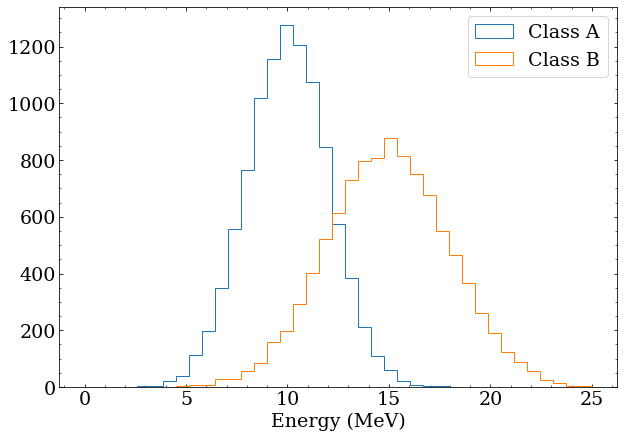

In [355]:
#设定本实验中的分区方式
binning = np.linspace(0,25,40)
# 定义产生 a,b 两类不同事件的自定义函数，nev 是所需产生的随机示例数。
def class_a(nev):
 return np.random.normal(10,2,size=nev)
def class_b(nev):
 return np.random.normal(15,3,size=nev)
#分别用定义好的 a,b 函数产生 1 万个随机事件，模拟已知分类示例
#并用直方图检查其分布特征。
mc_class_a = class_a(10000)
mc_class_b = class_b(10000)
plt.hist(mc_class_a,bins=binning,histtype='step',label='Class A')
plt.hist(mc_class_b,bins=binning,histtype='step',label='Class B')
plt.xlabel('Energy (MeV)')
plt.legend()

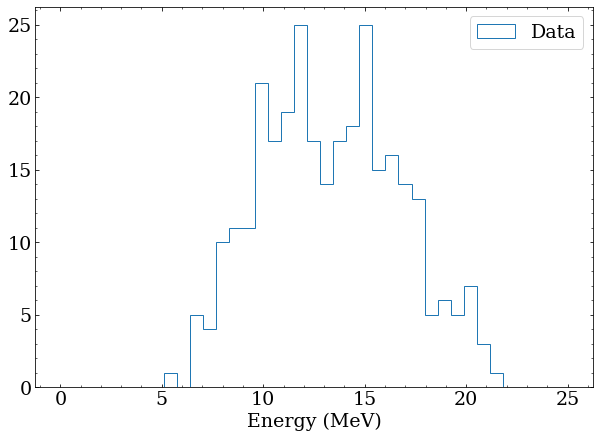

In [356]:
# 重新产生 100 个 A 事件和 200 个 B 事件，存于 data
data = np.concatenate([class_a(100),class_b(200)])
plt.hist(data,bins=binning,histtype='step',label='Data')
plt.xlabel('Energy (MeV)')
plt.legend()

#####  自定义似然函数类

In [357]:
# 定义 Likelihood 函数，采用类的方法
class LikelihoodFunction:
        
        def __init__(self,data,event_classes,binning):

        # 将数据分区加载至直方图 (k_i)
                self.data_counts = np.histogram(data,bins=binning)[0]
        # 每个事件类创建一个列表存储概率密度 PDF
                self.class_pdfs = []
                for event_class in event_classes:
        # 参考已识别案例对 AB 事件的数据进行分区
                        pdf_counts = np.histogram(event_class,bins=binning)[0]
        #归一化 PDF (H_ij)
                        pdf_norm = pdf_counts/np.sum(pdf_counts)
                        self.class_pdfs.append(pdf_norm)
        def __call__(self,*params):

        # 定义观测值 observed 为本类初始化分区后的直方图
                observed = self.data_counts
        # 期望值 expecteds 为归一化 PDFs 通过标度 scale 进行缩放的乘积
                expecteds = [scale*pdf for scale,pdf in zip(params,self.class_pdfs)]
        # 对期望值分区求和
                expected = np.sum(expecteds,axis=0)
        #-----------------------------------------------------------------------------
        #以下部分是直接采用泊松概率函数求似然函数
        #逐个区间计算观测到事件所对应的分区泊松概率
                bin_probabilities = poisson.pmf(observed,expected)
        #返回似然函数（用乘法）
                return np.prod(bin_probabilities)
        #直接泊松法求似然函数部分结束。
        # #------------------------------------------------------------------------------
        # #以下部分是对数法求似然函数
        # #对目标区域中的负值通过 mask 去掉，
        #         mask = expected > 0
        # #对观测值和参考值数据进行负对数求和，返回 log 型似然函数
        #         bin_nlls = expected[mask]-observed[mask]*np.log(expected[mask])
        #         return np.sum(bin_nlls)

In [358]:
#利用已知参考值 mc_class_a,mc_class_b 和待测值 data 初始化似然函数
lfn = LikelihoodFunction(data,[mc_class_a,mc_class_b],binning)
#输出不同参数的似然函数值
#print(lfn(150,150))
print(lfn(100,200))

3.2693510192119e-28


### 2. 极大似然函数分析



##### 检查似然函数空间

Text(0, 0.5, 'Class B Events')

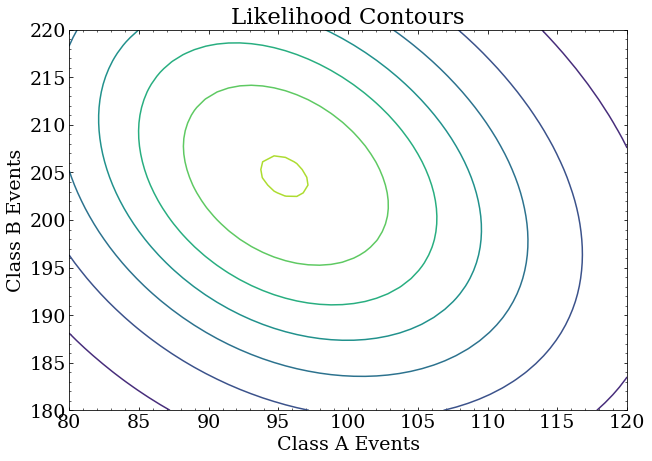

In [359]:
#产生二维的网格用于产生等高线
X,Y = np.meshgrid(np.linspace(80,120),np.linspace(180,220))
#根据 X,Y 的格点计算似然函数
Z = [lfn(x,y) for x,y in zip(X.flatten(),Y.flatten())]
#列表结果重整为二维矩阵，然后画等高图
Z = np.asarray(Z).reshape(X.shape)
plt.contour(X,Y,Z)
#plt.colorbar()
plt.title('Likelihood Contours')
plt.xlabel('Class A Events')
plt.ylabel('Class B Events')

In [360]:
#求负对数似然函数的最小值所对应的参数
nll_result = opt.minimize(lambda x: -lfn(*x),x0=(50,50),method='Nelder-Mead')
#输出极值对应结果。
print(nll_result)

 final_simplex: (array([[ 95.42041519, 204.57960299],
       [ 95.42044124, 204.57954709],
       [ 95.42038565, 204.57955466]]), array([-3.53104896e-28, -3.53104896e-28, -3.53104896e-28]))
           fun: -3.5310489593383077e-28
       message: 'Optimization terminated successfully.'
          nfev: 107
           nit: 56
        status: 0
       success: True
             x: array([ 95.42041519, 204.57960299])


### 3. 置信度水平

Text(0, 0.5, '-$\\Delta$ Log ${\\scr L}$')

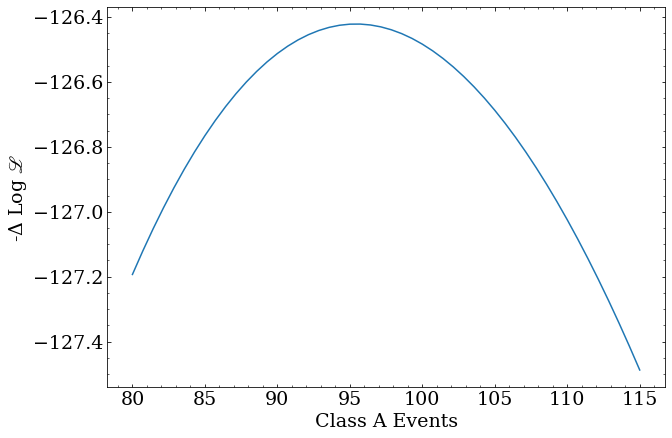

In [361]:
#分别定义 a 和 b 的 profile 函数，计算其中一个不变时，另一个的似然函数值
def profile_class_a(nev):
#b 不变时，导致的最小似然值的偏差
    return np.log(-opt.minimize(lambda x: -lfn(nev,x[0]),x0=(50,),method='Nelder-Mead').fun) + np.log(-nll_result.fun)
def profile_class_b(nev):
#a 不变时，导致的最小似然值的偏差
    return np.log(-opt.minimize(lambda x: -lfn(x[0],nev),x0=(50,),method='Nelder-Mead').fun) + np.log(-nll_result.fun)
#检查 profile 函数的输出结果，以 a 为例
x = np.linspace(80,115,50)
y = [profile_class_a(nev) for nev in x]
plt.plot(x,y)
plt.xlabel('Class A Events')
plt.ylabel('-$\Delta$ Log ${\scr L}$')

In [362]:
#利用 Scipy 的 brentq 函数求置信区间范围
def confidence_interval(delta_nll_fn,central,step):
#求满足 1sigma 的置信水平下，置信区间的上下限.
    lo = opt.brentq(lambda x: delta_nll_fn(x)-0.5,central-step,central)
    hi = opt.brentq(lambda x: delta_nll_fn(x)-0.5,central,central+step)
    return lo,hi
    #输出 a,b 的置信区间
central = nll_result.x[0]
lo,hi = confidence_interval(profile_class_a,central,50)
print('Number of A events = $%0.2f^{+%0.2f}_{-%0.2f}$'%(central,hi-central,central-lo))
central = nll_result.x[1]
lo,hi = confidence_interval(profile_class_b,central,50)
print('Number of B events = $%0.2f^{+%0.2f}_{-%0.2f}$'%(central,hi-central,central-lo))

ValueError: f(a) and f(b) must have different signs

### 4. 分析结果展示

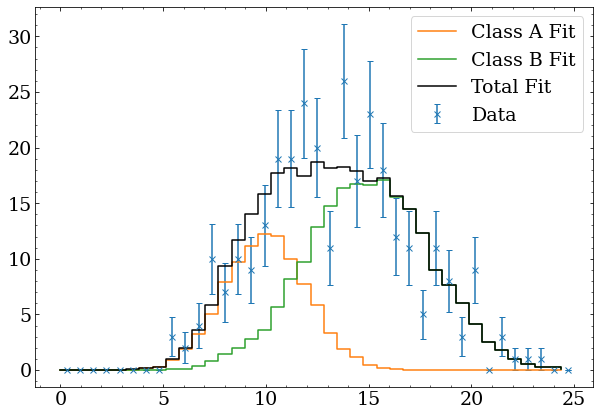

In [ ]:
#做出数据分区图和误差棒
bin_centers = (binning[:-1] + binning[1:])/2
plt.errorbar(bin_centers,lfn.data_counts,yerr=np.sqrt(lfn.data_counts),marker='x',linestyle='none',label='Data')
#用对数法极大似然结果作图
expecteds = [scale*pdf for scale,pdf in zip(nll_result.x,lfn.class_pdfs)]
#分别对 A,B 独立作图
for class_name,expected_class in zip(['A','B'],expecteds): 
    plt.plot(binning[:-1],expected_class,drawstyle='steps-post',label='Class %s Fit'%class_name)
#对期待值进行叠加求和
expected = np.sum(expecteds,axis=0)
plt.plot(binning[:-1],expected,drawstyle='steps-post',color='k',label='Total Fit')
plt.legend()
